In [1]:
import json
from datetime import datetime
import argparse
from scipy import ndimage
import torch
import torchvision
import os
import torchvision.transforms as transforms
from collections import defaultdict, OrderedDict
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm as tqdm
import time
import random
import yaml
import logging
import shutil
from models.resnet import *
from utils.utils import *
from utils.image_helper import ImageHelper
from utils.text_helper import TextHelper
logger = logging.getLogger('logger')
from prompt_toolkit import prompt
from training import *
from utils.utils import *
from IPython.display import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

In [2]:
with open('saved_models/model_image_Aug.15_11.40.44/params.yaml.txt', 'r') as f:
    params = yaml.load(f)
d = datetime.now().strftime('%b.%d_%H.%M.%S')
helper = ImageHelper(current_time=d, params=params, name='image')

In [108]:
helper.test_loader = torch.utils.data.DataLoader(helper.test_dataset, batch_size=1000,
                                                 shuffle=False, num_workers=2)

In [3]:
helper.device = 'cpu'

In [90]:
def load_model(path):
    dicts = torch.load(path)
    model = ResNet18()
    model.load_state_dict(dicts['state_dict'])
    model = model.to(helper.device)
    model.eval()
    return model

In [91]:
model = load_model('saved_models/model_image_Aug.15_11.40.44/model_last.pt.tar')

In [93]:
bck_model = load_model('saved_models/model_image_Aug.31_14.46.31/model_last.pt.tar')

In [100]:
progressed_model = load_model('saved_models/model_image_Aug.31_15.23.24/model_last.pt.tar')

In [63]:
helper.fix_random()

True

In [6]:
helper.load_cifar10(helper.batch_size)

Files already downloaded and verified
Files already downloaded and verified


True

In [7]:
criterion = nn.CrossEntropyLoss().to(helper.device)

In [8]:
test(run_helper=helper, model=model, criterion=criterion,  epoch=300)

100%|██████████| 100/100 [00:42<00:00,  2.51it/s]
Epoch 300. Poisoned: False. Accuracy: 95.22%


(95.22, 18.09149630460888)

In [9]:
test(run_helper=helper, model=bck_model, criterion=criterion,  epoch=300)

100%|██████████| 100/100 [00:42<00:00,  2.55it/s]
Epoch 300. Poisoned: False. Accuracy: 94.51%


(94.51, 20.980148700997233)

In [36]:
pil = transforms.ToPILImage()

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def show_img(img):
    from PIL import Image
    from IPython.display import HTML
    from io import BytesIO
    from base64 import b64encode

    b = BytesIO()  
    img.save(b, format='png')
    return HTML("<img style=\"width:100px; height:100px;\" src='data:image/png;base64,{0}'/>".format(b64encode(b.getvalue()).decode('utf-8')))

In [109]:
for batch,labels in helper.test_loader:
    batch = batch.to(helper.device)
    labels= labels.to(helper.device)
    break

In [110]:
bck_batch, bck_labels = poison_pattern(batch, labels, 8, 1.1)

In [41]:
bck_batch[3][0][2][24]

tensor(0.)


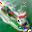

In [48]:
show_img(pil(inv_normalize(bck_batch[15])))


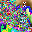

In [47]:
show_img(pil(bck_batch[15]))

In [111]:
# {model}{data}_{data}
# b - backdoor, n- normal, u-updated (normal training)
with torch.no_grad():
    nn_pred, nn_latent = model(batch)
    
    bn_pred, bn_latent = bck_model(batch)
    
    nb_pred, nb_latent = model(bck_batch)
    
    bb_pred, bb_latent = bck_model(bck_batch)
    
    un_pred, un_latent = progressed_model(batch)

In [112]:
torch.cosine_similarity(nn_latent, bn_latent, dim=1).mean()

tensor(0.9676)

In [113]:
torch.cosine_similarity(nn_latent, un_latent, dim=1).mean()

tensor(0.9995)

In [114]:
torch.norm(nn_latent-bn_latent, dim=1).mean()

tensor(1.3948)

In [115]:
torch.norm(nn_latent-un_latent, dim=1).mean()

tensor(0.1732)

In [119]:
figsize=(10,10)

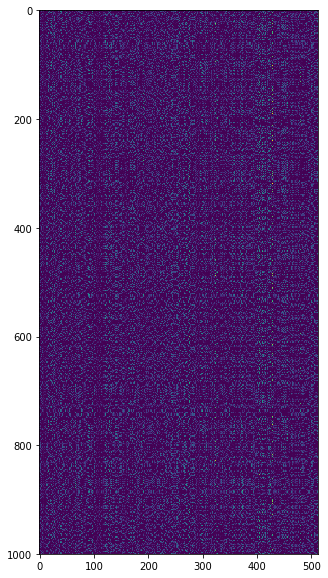

In [121]:
# Normal-normal
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(nn_latent.numpy())

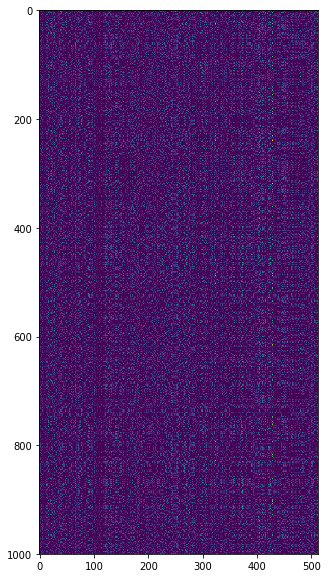

In [122]:
# Backdoored model - normal data
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(bn_latent.numpy())

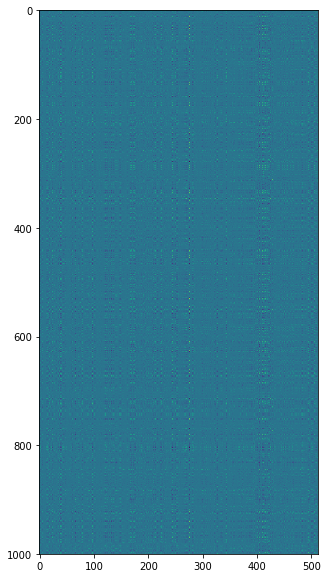

In [128]:
# normal data difference backdoored vs normal model
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow((nn_latent-bn_latent).numpy())

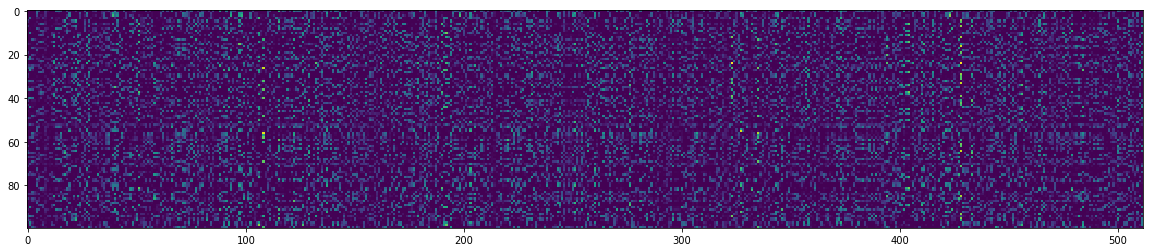

In [102]:
# Progressed model - normal data
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(un_latent.numpy())

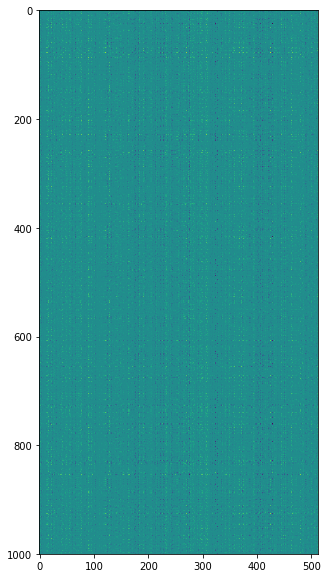

In [129]:
# Progressed model - normal data
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow((nn_latent-un_latent).numpy())

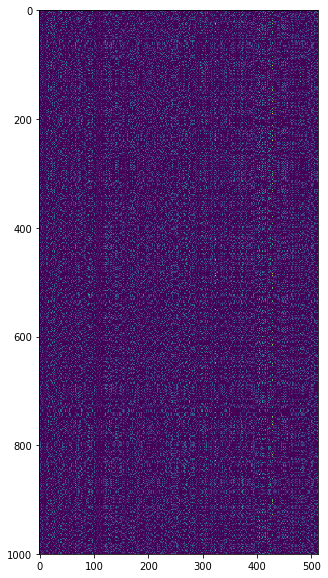

In [126]:
# Normal model on backdoor data
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow((nb_latent).numpy())

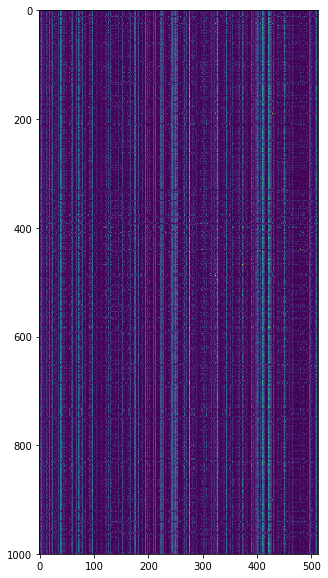

In [125]:
# Backdoored model on backdoor data
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(bb_latent.numpy())

In [18]:
i = transforms.ToPILImage(bck_batch[1])
show_img(i)

AttributeError: 'ToPILImage' object has no attribute 'save'

In [ ]:
batch_bck = 

In [18]:
ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True)

Files already downloaded and verified


In [57]:
ds[3][0], 1

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FACFCFA5AC8>, 1)

In [84]:
def poison_pattern(pilimg):
    """
    Poison the training batch by removing neighboring value with
    prob = poisoning and replacing it with the value with the pattern
    """
    image = pilimg.load()
    for i in range(3):
        image[2, 25] = (250,250,250)
        image[2, 24] = (0,0,0 )
        image[2, 23] = (250,250,250)

        image[6, 25] = (250,250,250)
        image[6, 24] = (0,0,0)
        image[6, 23] = (250,250,250)

        image[5, 24] = (250,250,250)
        image[4, 23] = (0,0,0)
        image[3, 24] = (250,250,250)


    return pilimg


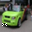

In [85]:
show_img(poison_pattern(ds[3678][0]))


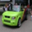

In [82]:
show_img(ds[3678][0])

In [75]:
a = ds[3678][0]

In [ ]:
a.

In [42]:
helper.test_dataset[1][0]

tensor([[[ 2.1264,  2.0489,  2.0682,  ...,  2.0876,  2.0876,  2.0682],
         [ 2.1845,  2.1264,  2.1264,  ...,  2.1458,  2.1458,  2.1264],
         [ 2.1652,  2.1070,  2.1070,  ...,  2.1264,  2.1264,  2.1070],
         ...,
         [-0.7426, -1.5955, -2.0608,  ...,  0.8470,  1.0990,  1.2153],
         [-0.8395, -1.5374, -1.7312,  ...,  0.9439,  1.1571,  1.1959],
         [-0.7813, -1.2272, -1.3047,  ...,  0.8276,  1.0602,  1.1765]],

        [[ 2.2035,  2.1248,  2.1445,  ...,  2.1641,  2.1641,  2.1445],
         [ 2.2625,  2.2035,  2.2035,  ...,  2.2231,  2.2231,  2.2035],
         [ 2.2428,  2.1838,  2.1838,  ...,  2.2035,  2.2035,  2.1838],
         ...,
         [-0.4712, -1.4152, -1.9659,  ...,  1.2004,  1.4561,  1.5544],
         [-0.5302, -1.2972, -1.5529,  ...,  1.2988,  1.5151,  1.5544],
         [-0.4319, -0.9432, -1.1006,  ...,  1.1808,  1.4168,  1.5151]],

        [[ 2.3635,  2.2855,  2.3050,  ...,  2.3245,  2.3245,  2.3050],
         [ 2.4221,  2.3635,  2.3635,  ...,  2

In [46]:
torch.max(model(x[0].to(helper.device)).data, 1)

torch.return_types.max(
values=tensor([9.4698, 9.3509, 7.5177, 8.1909, 9.7609, 9.7188, 8.7692, 9.9990, 9.2602,
        8.8302], device='cuda:0'),
indices=tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1], device='cuda:0'))

In [47]:
x[1]

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])